In [35]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import make_scorer
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn import svm
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import IsolationForest
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import ElasticNet, SGDRegressor
from sklearn.feature_selection import SelectKBest, chi2, f_regression, mutual_info_regression, RFE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scipy import stats

In [36]:
#os.system("kaggle competitions download -c blg454e-summer-2021")

In [37]:
sample_submission_loc = "blg454e-summer-2021/sampleSubmission.csv"
test0_loc = "blg454e-summer-2021/test_t0.csv"
train0_loc = "blg454e-summer-2021/train_t0.csv"
train1_loc = "blg454e-summer-2021/train_t1.csv"

In [38]:
test0_data = pd.read_csv(test0_loc)
train0_data = pd.read_csv(train0_loc)
train1_data = pd.read_csv(train1_loc)

In [39]:
def draw_scatter(data, x_range, y_range):
    fig, axs = plt.subplots(x_range, y_range)
        
    for i in range(x_range):
        for j in range(y_range):
            rand_temp = np.random.randint(0, len(data))
            axs[i, j].scatter(range(len(data[data.columns[rand_temp]])), data[data.columns[rand_temp]], c=np.random.rand(len(data[data.columns[rand_temp]])))
            axs[i, j].set_title(rand_temp)
    
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

In [40]:

def draw_hist(data, x_range, y_range):
    
    fig, axs = plt.subplots(x_range, y_range)
    
    for i in range(x_range):
        for j in range(y_range):
            rand_temp = np.random.randint(0, len(data))
            axs[i, j].hist(data[data.columns[rand_temp]])
            axs[i, j].set_title(rand_temp)
            
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
        

In [41]:
def draw_corr(data):
    plt.matshow(data.corr())
    plt.show()

In [42]:
def scatter_hist_helper(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')
    
def scatter_hist(data, f_1, f_2):
    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.005
    
    
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]
    
    # start with a square Figure
    fig = plt.figure(figsize=(8, 8))
    
    ax = fig.add_axes(rect_scatter)
    ax_histx = fig.add_axes(rect_histx, sharex=ax)
    ax_histy = fig.add_axes(rect_histy, sharey=ax)
    
    # use the previously defined function
    scatter_hist_helper(data[data.columns[f_1]], data[data.columns[f_2]], ax, ax_histx, ax_histy)
    
    plt.show()

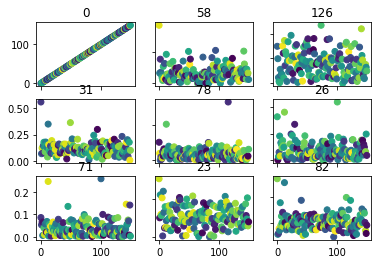

In [43]:
draw_scatter(train0_data, 3, 3)

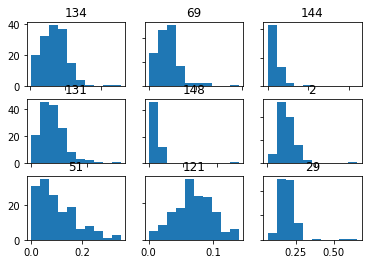

In [44]:
draw_hist(train0_data, 3, 3)

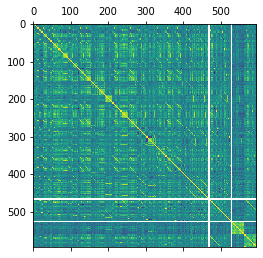

In [45]:
draw_corr(train0_data)

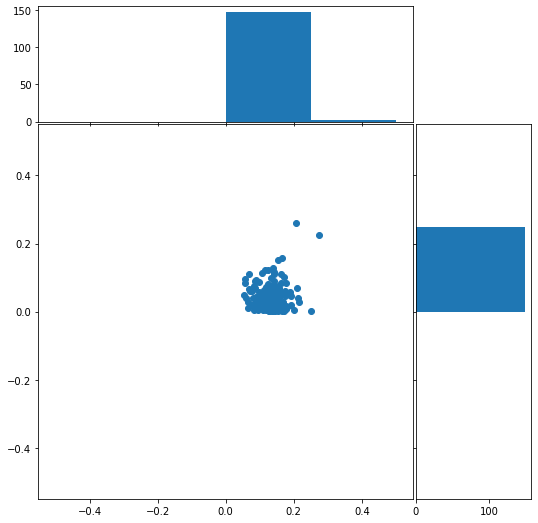

In [46]:
scatter_hist(train0_data, 10, 120)

In [47]:
def try_models(train,train_labels,test,test_labels, results):

    def test_model(model):

        model.fit(train, train_labels)
        test_predict = model.predict(test)
        actual = test_labels.flatten()
        predicted = test_predict.flatten()
        scores = mse(predicted, actual)

        return scores

    model = linear_model.LinearRegression()
    test_result = test_model(model)
    model_name = 'LinearRegression'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})
    
    model = linear_model.Ridge()
    test_result = test_model(model)
    model_name = 'Ridge'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})

    model = MultiOutputRegressor(SGDRegressor())
    test_result = test_model(model)
    model_name = 'SGDRegressor'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})

    model = MultiOutputRegressor(linear_model.BayesianRidge())
    test_result = test_model(model)
    model_name = 'BayesianRidge'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})
    
    model = MultiOutputRegressor(linear_model.HuberRegressor())
    test_result = test_model(model)
    model_name = 'HuberRegressor'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})
    
    model = linear_model.Lasso(alpha=1e-4)
    test_result = test_model(model)
    model_name = 'Lasso'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})
        
    model = BaggingRegressor()
    test_result = test_model(model)
    model_name = 'BaggingRegressor'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})

    model = ElasticNet()
    test_result = test_model(model)
    model_name = 'ElasticNet'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})
    
    model = RandomForestRegressor()
    test_result = test_model(model)
    model_name = 'RandomForestRegressor'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})

    model = MultiOutputRegressor(AdaBoostRegressor())
    test_result = test_model(model)
    model_name = 'AdaBoostRegressor'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})
    
    model = MultiOutputRegressor(svm.SVR(kernel="linear"))
    test_result = test_model(model)
    model_name = 'SVR(kernel="linear")'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})
       
    model = MultiOutputRegressor(svm.SVR(kernel="rbf"))
    test_result = test_model(model)
    model_name = 'SVR(kernel="rbf")'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})
    
    return results

In [48]:
random.seed(1)
def cv(data, labels, n_fold, model=None, shuffle=False):
    kf = KFold(n_splits=n_fold, shuffle=shuffle)
    results = {}
    if model is not None:
        results['YourModel'] = []
    for train_index, test_index in kf.split(data):
        train = data[train_index, :]
        train_labels = labels[train_index, :]
        test = data[test_index, :]
        test_labels = labels[test_index, :]

        scaler = MinMaxScaler()
        scaler.fit(train)
        train = scaler.transform(train)
        test = scaler.transform(test)

        pca = PCA(0.70)
        pca.fit(train)
        train = pca.transform(train)
        test = pca.transform(test)

        if model == None:
            results = try_models(train,train_labels,test,test_labels, results)
        else:
            model.fit(train, train_labels)
            test_predict = model.predict(test)
            actual = test_labels.flatten()
            predicted = test_predict.flatten()
            scores = mse(predicted, actual)
            results['YourModel'].append(scores)

    results_df = pd.DataFrame(results).T
    variance = results_df.var(axis=1)
    mean = results_df.mean(axis=1)
    results_df.insert(5, "Var", variance)
    results_df.insert(6, "Mean", mean)  

    return results_df

In [49]:

def train_model_and_predict(model, data, labels, test):
    scaler = StandardScaler()
    scaler.fit(data)
    train = scaler.transform(data)

    pca = PCA(0.70)
    pca.fit(train)
    train = pca.transform(train)
    model.fit(train, labels)
    
    test_data = scaler.transform(test)
    test_data = pca.transform(test_data)
    prediction = model.predict(test_data)

    return model, prediction